# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Загрузите датасет с Kaggle.

In [ ]:
pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jjjjuuuli","key":"57a8f8e127b5ae84d6a1c50cff22afa8"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!  cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

401 - Unauthorized - Unauthenticated


In [ ]:
pip install torchinfo

In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
import zipfile as zf
from zipfile import ZipFile

from timeit import default_timer as timer
from tqdm.notebook import tqdm
from typing import Tuple, List, Dict

import random
import os
import glob
import itertools
import time
import pathlib
import kaggle
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torchinfo import summary

from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from collections import OrderedDict


In [ ]:
if os.path.isdir('data') == False:
    os.mkdir('data')

In [ ]:
path_data = 'data/oxford_pets'

In [ ]:
if os.path.isdir(path_data) == False:
    os.chdir('data/')

    !kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset

    with zf.ZipFile('the-oxfordiiit-pet-dataset.zip', 'r') as file:
        file.extractall('.')

    os.rename('images', 'oxford_pets')
    os.remove('the-oxfordiiit-pet-dataset.zip')

    os.chdir('..')

100% 1.47G/1.48G [00:19<00:00, 94.5MB/s]
100% 1.48G/1.48G [00:19<00:00, 82.9MB/s]


In [ ]:
def plot_classes_images(data: pd.DataFrame, class_names: list) -> None:
    font_s = 12

    n_images = len(class_names)
    fig = plt.figure(figsize=(16, n_images / 2))

    cols = 8
    rows = n_images // cols + int((n_images % cols) / 10) + 1

    for i, name in enumerate(class_names):
        fig.add_subplot(rows, cols, i+1)

        image = data.query('label == @name').sample(1)

        img = Image.open(image['file_path'].item())

        plt.imshow(img)
        plt.axis('off')

        plt.title(image['label'].item(), fontsize=font_s+4)

        plt.tight_layout()

In [ ]:
df = pd.DataFrame(glob.glob(f'{path_data}/*.jpg'), columns=['file_path'])
df['file_path'] = df['file_path'].apply(lambda x: x.replace('\\', '/'))
df['file_name'] = df['file_path'].str.split(f'{path_data}/').str[1]
df['label'] = df['file_name'].str.rsplit('_').str[0]
df.head()

,file_path,file_name,label
0,data/oxford_pets/keeshond_176.jpg,keeshond_176.jpg,keeshond
1,data/oxford_pets/english_cocker_spaniel_79.jpg,english_cocker_spaniel_79.jpg,english
2,data/oxford_pets/pomeranian_112.jpg,pomeranian_112.jpg,pomeranian
3,data/oxford_pets/samoyed_101.jpg,samoyed_101.jpg,samoyed
4,data/oxford_pets/Sphynx_49.jpg,Sphynx_49.jpg,Sphynx


In [ ]:
class_names = df['label'].unique()
class_names

array(['keeshond', 'english', 'pomeranian', 'samoyed', 'Sphynx', 'Bengal',
       'great', 'Siamese', 'wheaten', 'Bombay', 'saint', 'Russian',
       'Birman', 'japanese', 'boxer', 'havanese', 'Persian', 'British',
       'beagle', 'Egyptian', 'scottish', 'yorkshire', 'leonberger',
       'basset', 'miniature', 'chihuahua', 'american', 'german',
       'Ragdoll', 'newfoundland', 'shiba', 'pug', 'Maine',
       'staffordshire', 'Abyssinian'], dtype=object)

In [ ]:
cats = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British', 'Egyptian',
        'Maine', 'Persian', 'Ragdoll', 'Russian', 'Siamese', 'Sphynx']
dogs = ['american', 'basset', 'beagle',  'boxer', 'chihuahua', 'english',
       'german', 'great', 'havanese', 'japanese', 'keeshond',
       'leonberger', 'miniature', 'newfoundland',
       'pomeranian', 'pug', 'saint', 'samoyed',
       'scottish', 'shiba', 'staffordshire',
       'wheaten', 'yorkshire']

In [ ]:
df['label'] = df['label'].apply(lambda x: f'cat_{x}' if x in cats else f'dog_{x}')

In [ ]:
class_names = df['label'].unique()
class_names

array(['dog_keeshond', 'dog_english', 'dog_pomeranian', 'dog_samoyed',
       'cat_Sphynx', 'cat_Bengal', 'dog_great', 'cat_Siamese',
       'dog_wheaten', 'cat_Bombay', 'dog_saint', 'cat_Russian',
       'cat_Birman', 'dog_japanese', 'dog_boxer', 'dog_havanese',
       'cat_Persian', 'cat_British', 'dog_beagle', 'cat_Egyptian',
       'dog_scottish', 'dog_yorkshire', 'dog_leonberger', 'dog_basset',
       'dog_miniature', 'dog_chihuahua', 'dog_american', 'dog_german',
       'cat_Ragdoll', 'dog_newfoundland', 'dog_shiba', 'dog_pug',
       'cat_Maine', 'dog_staffordshire', 'cat_Abyssinian'], dtype=object)

In [ ]:
def train_test_split(data: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    test_len = int(test_size * len(data))

    test = data.sample(test_len)
    train = data.drop(test.index, axis=0)

    test = test.reset_index(drop=True)
    train = train.reset_index(drop=True)

    return train, test

In [ ]:
train_data_df, valid_test_data = train_test_split(df, test_size=0.25)
valid_data_df, test_data_df = train_test_split(valid_test_data, test_size=0.5)

In [ ]:
def get_classes(files_df: pd.DataFrame) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(files_df['label'].unique())
    class_to_idx = {name: i for i, name in enumerate(classes)}

    return classes, class_to_idx


In [ ]:
class ImageFolderCustom(Dataset):

    def __init__(self,
                 target_dir: str,
                 files_df: pd.Series,
                 transform: torchvision.transforms.transforms.Compose = None) -> None:

        self.files_df = files_df
        self.paths = [list(pathlib.Path(target_dir).glob(name))[0] for name in self.files_df['file_name']]
        self.transform = transform
        self.classes, self.class_to_idx = get_classes(files_df)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name  = self.files_df.iloc[index]['label']
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
train_df = ImageFolderCustom(path_data, train_data_df, train_transforms)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_df,
    batch_size=64,
    shuffle=True
)

#VGG

In [ ]:
SIZE = 224
BATCH_SIZE = 4

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

valid_transforms = transforms.Compose([
    transforms.Resize(SIZE + 32),
    transforms.CenterCrop(SIZE),
    transforms.ToTensor(),
])

In [ ]:
train_df_vgg16 = ImageFolderCustom(path_data, train_data_df, train_transforms)
valid_df_vgg16 = ImageFolderCustom(path_data, valid_data_df, valid_transforms)

In [ ]:
train_dataloader_vgg16 = torch.utils.data.DataLoader(
    dataset=train_df_vgg16,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader_vgg16 = torch.utils.data.DataLoader(
    dataset=valid_df_vgg16,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s]


In [ ]:
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, len(class_names))

In [ ]:
for parametrs in vgg16.features.parameters():
    parametrs.requires_grad = False

In [ ]:
def get_targets(data: ImageFolderCustom) -> torch.Tensor:
    return torch.IntTensor(data.files_df['label'].apply(lambda x: data.class_to_idx[x]))

In [ ]:
def check_time(start: float, end: float, device: torch.device) -> None:
    total_time = end - start
    print(f'\nTotal train time on {device}: {total_time:.3f} seconds')

In [ ]:
def plot_loss_curves(loss: List[float],
                     accuracy: List[float],
                     loss_val: List[float] = None,
                     accuracy_val: List[float] = None) -> None:

    font_s = 12
    titles = ['Loss', 'Accuracy']

    epochs = range(len(loss))
    n_cols = len(titles)

    fig, ax = plt.subplots(1, n_cols, figsize=(16,5))

    for i in range(n_cols):
        key = n_cols * i

        ax[i].plot(epochs, [loss, accuracy][i], label=f'{titles[i].lower()}_train')

        if loss_val is not None and accuracy_val is not None:
            ax[i].plot(epochs, [loss_val, accuracy_val][i], label=f'{titles[i].lower()}_val')

        ax[i].set_title(titles[i], fontsize=font_s+4)
        ax[i].set_xlabel('Epochs', fontsize=font_s)

        ax[i].legend(loc='upper right')
        ax[i].grid()

        i += 1

In [ ]:
class IMGClassifier:

    def __init__(self, model: torch.nn.Module, device: torch.device) -> None:
        self.model = model
        self.device = device

        self.model = self.model.to(device)


    def train(self,
              train_dataloader: torch.utils.data.DataLoader,
              valid_dataloader: torch.utils.data.DataLoader,
              n_epochs: int,
              criterion: torch.nn.Module,
              optimizer: torch.optim.Optimizer = None,
              scheduler: torch.optim.lr_scheduler.StepLR = None) -> Tuple[float, float]:

        self.train_dataloader = train_dataloader
        self.criterion = criterion

        self.loss_acc_hist = []

        # start timer
        start_time = timer()

        for epoch in tqdm(range(n_epochs), 'Training process'):
            print(f'Epoch [{epoch+1}/{n_epochs}]')

            # training
            train_valid = {'train': train_dataloader,
                           'valid': valid_dataloader}

            for phase, dataloader in train_valid.items():
                self.__phase = phase

                if self.__phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                loss, acc, predictions = self.predict(dataloader, optimizer, scheduler)

                print(f'{self.__phase.upper()}   Loss: {loss:.4f}   Accuracy: {acc:.4f}')

                if self.__phase == 'train':
                    self.loss_acc_hist.append([loss, acc])

            print()

        end_time = timer()
        check_time(start_time, end_time, self.device)

        # plot results
        self.loss_acc_hist = np.array(self.loss_acc_hist)
        plot_loss_curves(self.loss_acc_hist[:, 0], self.loss_acc_hist[:, 1])


    def predict(self,
                dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer = None,
                scheduler: torch.optim.lr_scheduler.StepLR = None) -> Tuple[float, float, torch.Tensor]:

        loss_total, acc_total = 0.0, 0.0
        predictions = []

        for imgs, labels in tqdm(dataloader, 'Iterating the dataloader'):
            imgs, labels = imgs.to(self.device), labels.to(self.device)

            loss, acc, y_pred_class = self.forward_backward(imgs, labels, optimizer)

            loss_total += loss * imgs.size(0)
            acc_total += acc
            predictions.extend(y_pred_class)

        if scheduler != None and self.__phase == 'train':
            scheduler.step()

        loss_total = loss_total / len(dataloader)
        acc_total = acc_total / len(dataloader)

        return loss_total, acc_total, predictions


    def forward_backward(self,
                         imgs: torch.Tensor,
                         labels: torch.Tensor,
                         optimizer: torch.optim.Optimizer) -> Tuple[float, float, torch.Tensor]:

        if optimizer != None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(self.__phase == 'train'):
            # forward
            y_pred = self.model(imgs)
            loss = self.criterion(y_pred, labels)

            y_pred_class = torch.argmax(torch.softmax(y_pred.data, dim=1), dim=1)
            acc = (y_pred_class == labels).sum() / len(y_pred)

            # backward
            if self.__phase == 'train':
                loss.backward()

                if optimizer != None:
                    optimizer.step()

            return loss.item(), acc.item(), y_pred_class.cpu().detach().numpy()


    def get_top(self, n_top: int) -> pd.DataFrame:
        loss_acc_df = pd.DataFrame(
            self.loss_acc_hist,
            columns=['loss', 'accuracy']
        ).sort_values(by='accuracy', ascending=False)

        top = [loss_acc_df.iloc[0]]

        for i in range(len(loss_acc_df)):
            loss_acc = list(loss_acc_df.iloc[i])

            if loss_acc[1] not in np.array(top)[:, 1]:
                top.append(loss_acc)

            if len(top) == n_top:
                display(pd.DataFrame(np.array(top), columns=['loss', 'accuracy']))
                return

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [ ]:
model_vgg16 = IMGClassifier(vgg16, device)

In [ ]:
N_EPOCHS = 30
LEARN_R = 0.001

CRITERION = nn.CrossEntropyLoss()
OPTIM = optim.SGD(vgg16.classifier.parameters(), lr=LEARN_R)

Training process:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.1408   Accuracy: 0.9926


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9298   Accuracy: 0.8539

Epoch [2/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.1336   Accuracy: 0.9926


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.8531   Accuracy: 0.8604

Epoch [3/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.1245   Accuracy: 0.9930


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9283   Accuracy: 0.8626

Epoch [4/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.1096   Accuracy: 0.9951


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9273   Accuracy: 0.8647

Epoch [5/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.1111   Accuracy: 0.9940


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.8918   Accuracy: 0.8669

Epoch [6/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.1018   Accuracy: 0.9939


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.8824   Accuracy: 0.8658

Epoch [7/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0967   Accuracy: 0.9949


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9426   Accuracy: 0.8636

Epoch [8/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0917   Accuracy: 0.9960


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9122   Accuracy: 0.8636

Epoch [9/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0855   Accuracy: 0.9960


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9648   Accuracy: 0.8701

Epoch [10/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0833   Accuracy: 0.9962


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9547   Accuracy: 0.8658

Epoch [11/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0805   Accuracy: 0.9962


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0087   Accuracy: 0.8615

Epoch [12/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0834   Accuracy: 0.9962


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9765   Accuracy: 0.8647

Epoch [13/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0651   Accuracy: 0.9975


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9128   Accuracy: 0.8755

Epoch [14/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0591   Accuracy: 0.9969


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9072   Accuracy: 0.8755

Epoch [15/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0699   Accuracy: 0.9966


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9868   Accuracy: 0.8593

Epoch [16/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0628   Accuracy: 0.9977


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9497   Accuracy: 0.8723

Epoch [17/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0632   Accuracy: 0.9966


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9561   Accuracy: 0.8647

Epoch [18/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0613   Accuracy: 0.9971


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9992   Accuracy: 0.8680

Epoch [19/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0680   Accuracy: 0.9959


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9713   Accuracy: 0.8723

Epoch [20/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0609   Accuracy: 0.9980


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9735   Accuracy: 0.8636

Epoch [21/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0543   Accuracy: 0.9980


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0332   Accuracy: 0.8658

Epoch [22/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0491   Accuracy: 0.9982


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9701   Accuracy: 0.8636

Epoch [23/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0419   Accuracy: 0.9989


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0072   Accuracy: 0.8701

Epoch [24/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0543   Accuracy: 0.9968


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9783   Accuracy: 0.8701

Epoch [25/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0463   Accuracy: 0.9982


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9933   Accuracy: 0.8636

Epoch [26/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0499   Accuracy: 0.9973


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0093   Accuracy: 0.8680

Epoch [27/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0446   Accuracy: 0.9982


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0517   Accuracy: 0.8690

Epoch [28/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0506   Accuracy: 0.9971


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0093   Accuracy: 0.8669

Epoch [29/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0407   Accuracy: 0.9987


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0101   Accuracy: 0.8734

Epoch [30/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 0.0424   Accuracy: 0.9982


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 2.0223   Accuracy: 0.8690


Total train time on cuda: 2653.948 seconds


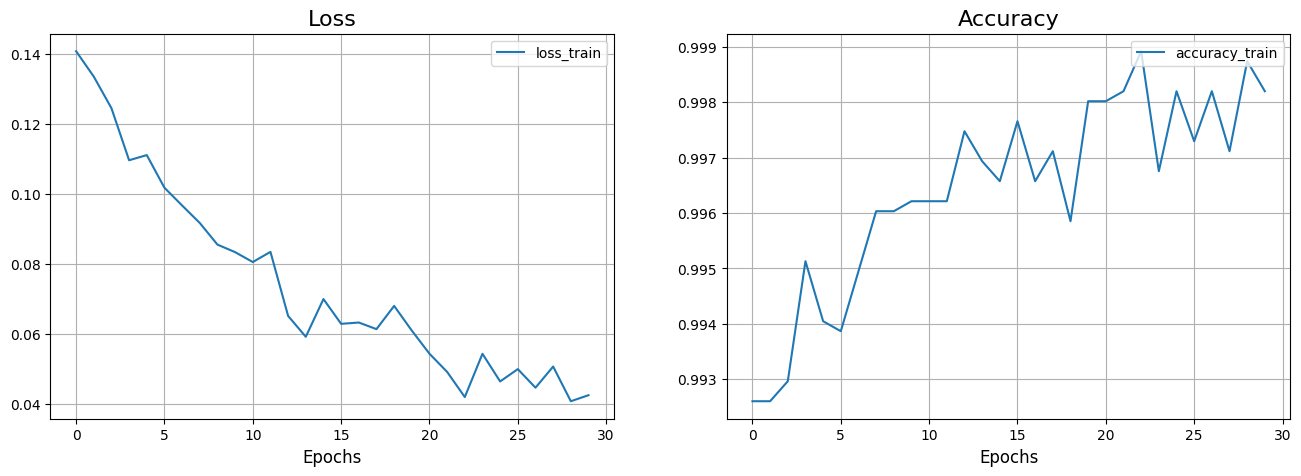

In [ ]:
model_vgg16.train(
    n_epochs=N_EPOCHS,
    train_dataloader=train_dataloader_vgg16,
    valid_dataloader=valid_dataloader_vgg16,
    criterion=CRITERION,
    optimizer=OPTIM
)

Top 3 accuracy

In [ ]:
model_vgg16.get_top(3)

,loss,accuracy
0,0.041885,0.998918
1,0.040689,0.998737
2,0.042410,0.998196


Top 5 accuracy

In [ ]:
model_vgg16.get_top(5)

,loss,accuracy
0,0.041885,0.998918
1,0.040689,0.998737
2,0.042410,0.998196
3,0.060898,0.998016
4,0.062831,0.997655


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def get_classification_report(targets: list,
                              predictions: list,
                              class_names: list) -> pd.DataFrame:

    return pd.DataFrame(
        classification_report(
            targets,
            predictions,
            target_names=class_names,
            output_dict=True
        )).T.sort_values(by=['precision', 'recall', 'f1-score'], ascending=False)

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
test_data = ImageFolderCustom(path_data, test_data_df, test_transforms)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_predictions = model_vgg16.predict(test_dataloader)[-1]

Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

In [ ]:
model_vgg16_class = get_classification_report(
    get_targets(test_data),
    test_predictions,
    class_names
)

Точность классификатора для каждой породы кошек и собак

In [ ]:
model_vgg16_class

,precision,recall,f1-score,support
dog_beagle,1.000000,0.923077,0.960000,26.000000
dog_great,1.000000,0.727273,0.842105,22.000000
dog_yorkshire,0.971429,0.944444,0.957746,36.000000
dog_american,0.966667,1.000000,0.983051,29.000000
dog_pug,0.966667,0.878788,0.920635,33.000000
dog_leonberger,0.962963,0.928571,0.945455,28.000000
cat_Ragdoll,0.961538,0.892857,0.925926,28.000000
dog_havanese,0.960000,0.774194,0.857143,31.000000
cat_British,0.959184,0.870370,0.912621,54.000000
dog_newfoundland,0.944444,0.894737,0.918919,19.000000


In [ ]:
def filter_df(df: pd.DataFrame,
              value: str) -> pd.DataFrame:

    return pd.DataFrame(
        df.reset_index()[
            df.reset_index()['index'].str.contains(value)
        ].sum(),
        columns=[f'{value}s']
    ).drop('index', axis=0)

In [ ]:
def binary_class(df: pd.DataFrame) -> pd.DataFrame:
    updated_df = filter_df(df, 'cat').join(filter_df(df, 'dog'))

    total_cats = sum(df.reset_index()['index'].str.contains('cat'))
    total_dogs = len(df) - total_cats

    updated_df['cats'] = updated_df['cats'] / total_cats
    updated_df['dogs'] = updated_df['dogs'] / total_dogs

    return updated_df

Точность классификатора для бинарной классификации (кошки/собаки)

In [ ]:
binary_class(model_vgg16_class)

,cats,dogs
precision,0.825637,0.748916
recall,0.821718,0.749423
f1-score,0.820453,0.744697
support,30.25,21.538462


Confusion matrix

In [ ]:
def display_confusion_matrix(predictions: List[int],
                             data: ImageFolderCustom,
                             class_names: List[str]) -> None:

    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(
        preds=torch.IntTensor(predictions),
        target=get_targets(data)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10,10)
    )

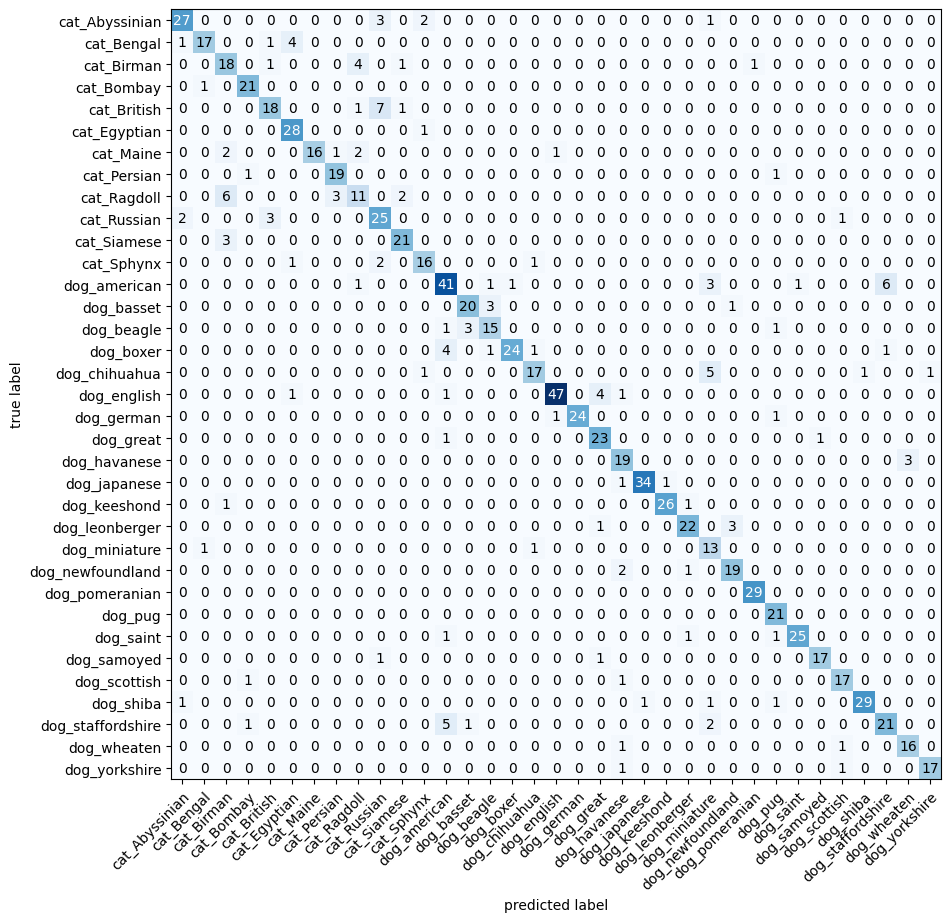

In [ ]:
display_confusion_matrix(
    test_predictions,
    test_data,
    model_vgg16.train_dataloader.dataset.classes
)

#ResNet

In [ ]:
train_data_resnet18 = ImageFolderCustom(path_data, train_data_df, train_transforms)
valid_data_resnet18 = ImageFolderCustom(path_data, valid_data_df, valid_transforms)

In [ ]:
train_dataloader_resnet18 = torch.utils.data.DataLoader(
    dataset=train_data_resnet18,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader_resnet18 = torch.utils.data.DataLoader(
    dataset=valid_data_resnet18,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [ ]:
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(class_names))

In [ ]:
model_resnet18 = IMGClassifier(resnet18, device)

In [ ]:
OPTIM = optim.SGD(resnet18.parameters(), lr=LEARN_R)
SCHEDULER = optim.lr_scheduler.StepLR(OPTIM, step_size=7, gamma=0.1)

Training process:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 10.2485   Accuracy: 0.3855


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 3.8706   Accuracy: 0.8128

Epoch [2/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 5.7334   Accuracy: 0.6809


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.9847   Accuracy: 0.8690

Epoch [3/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 4.0791   Accuracy: 0.7692


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.4930   Accuracy: 0.8885

Epoch [4/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 3.2840   Accuracy: 0.7992


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.2177   Accuracy: 0.9134

Epoch [5/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 2.8235   Accuracy: 0.8247


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.0581   Accuracy: 0.9242

Epoch [6/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 2.4766   Accuracy: 0.8445


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.1461   Accuracy: 0.9069

Epoch [7/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 2.1860   Accuracy: 0.8590


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9106   Accuracy: 0.9275

Epoch [8/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.9255   Accuracy: 0.8766


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9605   Accuracy: 0.9210

Epoch [9/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.8728   Accuracy: 0.8819


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9540   Accuracy: 0.9177

Epoch [10/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.9548   Accuracy: 0.8813


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9719   Accuracy: 0.9210

Epoch [11/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.8474   Accuracy: 0.8907


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.8854   Accuracy: 0.9286

Epoch [12/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.8701   Accuracy: 0.8886


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9141   Accuracy: 0.9232

Epoch [13/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.8221   Accuracy: 0.8917


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9504   Accuracy: 0.9199

Epoch [14/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7808   Accuracy: 0.8891


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.8971   Accuracy: 0.9275

Epoch [15/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.6804   Accuracy: 0.9006


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.8727   Accuracy: 0.9318

Epoch [16/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7698   Accuracy: 0.8953


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9911   Accuracy: 0.9188

Epoch [17/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7371   Accuracy: 0.8950


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9443   Accuracy: 0.9177

Epoch [18/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7187   Accuracy: 0.8950


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9694   Accuracy: 0.9232

Epoch [19/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7285   Accuracy: 0.8977


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 1.0038   Accuracy: 0.9102

Epoch [20/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7006   Accuracy: 0.9011


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9542   Accuracy: 0.9210

Epoch [21/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.8013   Accuracy: 0.8900


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9205   Accuracy: 0.9221

Epoch [22/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.6855   Accuracy: 0.9004


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9287   Accuracy: 0.9210

Epoch [23/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7887   Accuracy: 0.8887


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9532   Accuracy: 0.9253

Epoch [24/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7091   Accuracy: 0.9004


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9468   Accuracy: 0.9177

Epoch [25/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7416   Accuracy: 0.8930


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.8550   Accuracy: 0.9286

Epoch [26/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7645   Accuracy: 0.8932


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9614   Accuracy: 0.9210

Epoch [27/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7565   Accuracy: 0.8959


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9187   Accuracy: 0.9242

Epoch [28/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.6823   Accuracy: 0.9030


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9174   Accuracy: 0.9275

Epoch [29/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.7230   Accuracy: 0.8975


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9122   Accuracy: 0.9297

Epoch [30/30]


Iterating the dataloader:   0%|          | 0/1386 [00:00<?, ?it/s]

TRAIN   Loss: 1.6736   Accuracy: 0.9028


Iterating the dataloader:   0%|          | 0/231 [00:00<?, ?it/s]

VALID   Loss: 0.9062   Accuracy: 0.9318


Total train time on cuda: 1854.851 seconds


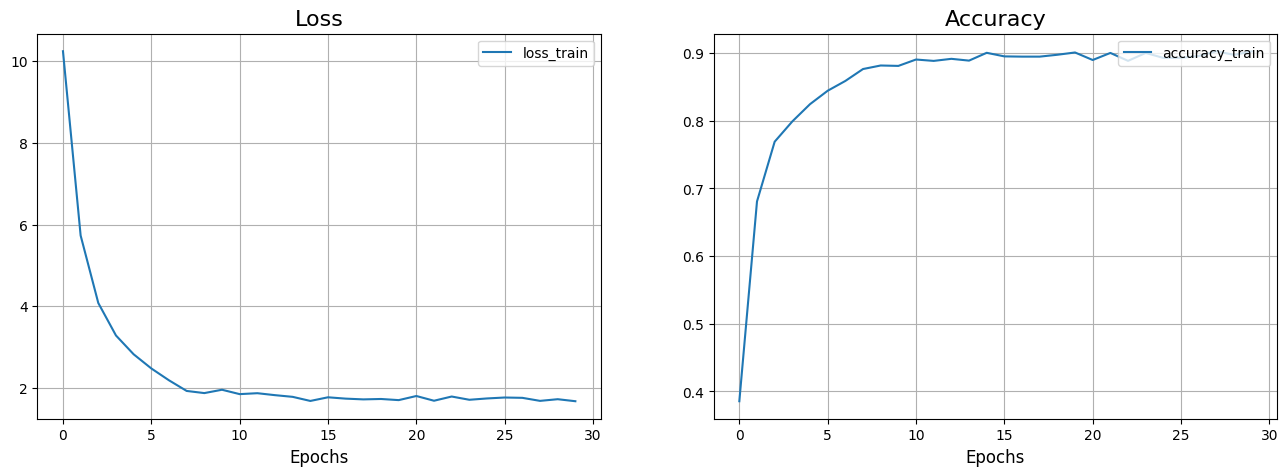

In [ ]:
model_resnet18.train(
    n_epochs=N_EPOCHS,
    train_dataloader=train_dataloader_resnet18,
    valid_dataloader=valid_dataloader_resnet18,
    criterion=CRITERION,
    optimizer=OPTIM,
    scheduler=SCHEDULER
)

In [ ]:
model_resnet18.get_top(3)

,loss,accuracy
0,1.682303,0.902958
1,1.673638,0.902778
2,1.700580,0.901094


In [ ]:
model_resnet18.get_top(5)

,loss,accuracy
0,1.682303,0.902958
1,1.673638,0.902778
2,1.700580,0.901094
3,1.680388,0.900613
4,1.709066,0.900433


In [ ]:
model_resnet18_class = get_classification_report(
    get_targets(test_data),
    test_predictions,
    class_names
)

Тончость классификатора для каждой породы кошек и собак

In [ ]:
model_resnet18_class

,precision,recall,f1-score,support
dog_beagle,1.000000,0.923077,0.960000,26.000000
dog_great,1.000000,0.727273,0.842105,22.000000
dog_yorkshire,0.971429,0.944444,0.957746,36.000000
dog_american,0.966667,1.000000,0.983051,29.000000
dog_pug,0.966667,0.878788,0.920635,33.000000
dog_leonberger,0.962963,0.928571,0.945455,28.000000
cat_Ragdoll,0.961538,0.892857,0.925926,28.000000
dog_havanese,0.960000,0.774194,0.857143,31.000000
cat_British,0.959184,0.870370,0.912621,54.000000
dog_newfoundland,0.944444,0.894737,0.918919,19.000000


Точность для бинарной классификации (кошки/собаки)

In [ ]:
binary_class(model_resnet18_class)

,cats,dogs
precision,0.825637,0.748916
recall,0.821718,0.749423
f1-score,0.820453,0.744697
support,30.25,21.538462


Confusion matrix

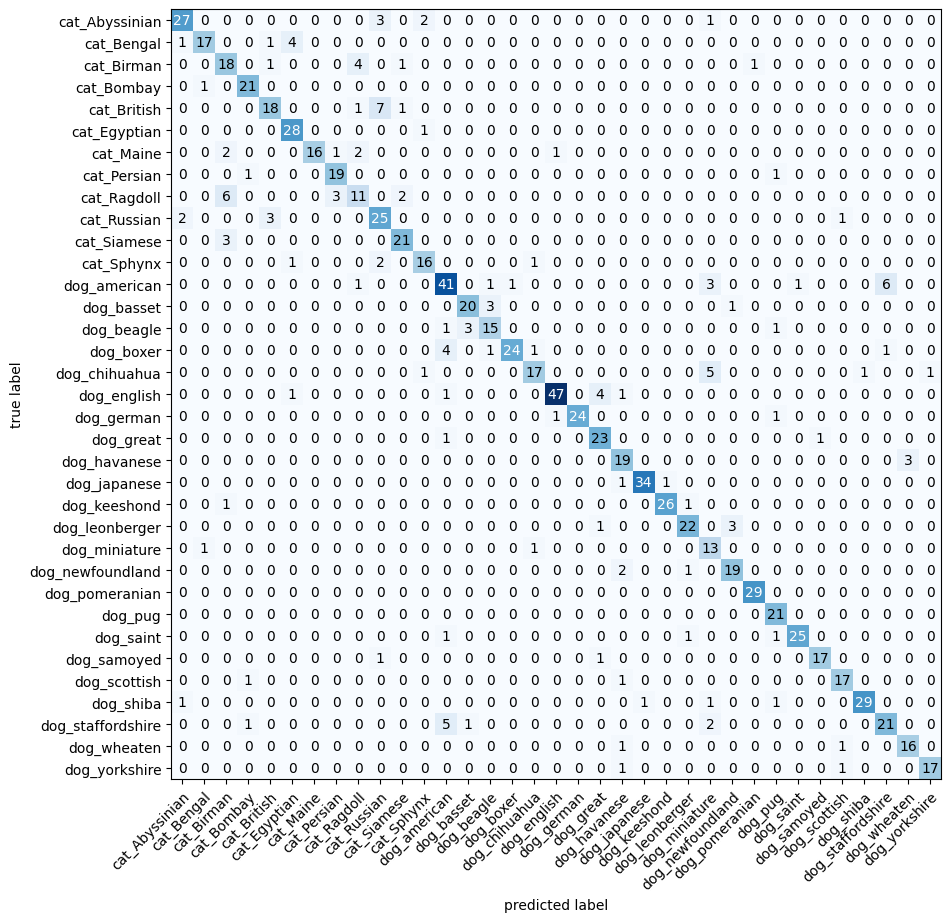

In [ ]:
display_confusion_matrix(
    test_predictions,
    test_data,
    model_resnet18.train_dataloader.dataset.classes
)